# 1 Import Packages

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [1]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import os
from google.colab.patches import cv2_imshow



```
# This is formatted as code
```

# 2 Dataset

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


The dataset used here is Real-world Affective Faces Database [RAF-DB](https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/) on Kaggle
, a collection of facial expression images in 7 classes ('suprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral'). These images are cropped for you. Other people have done face detection already and put the resulted detected faces/cropped faces here.

Original paper published with RAF-DB: [Reliable Crowdsourcing and Deep Locality-Preserving Learning for Expression
 Recognition in the Wild, CVPR 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Li_Reliable_Crowdsourcing_and_CVPR_2017_paper.pdf).

In [2]:
%%capture
!pip install -q opendatasets

In [3]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/') # insert ypu kaggle username and key

## 2.2 PyTorch Dataset and Dataloader

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.ImageFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [4]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for facial expression recognition.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/MMU/DeepLearning/dataset/raf-db-dataset/DATASET/train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/MMU/DeepLearning/dataset/raf-db-dataset/DATASET/test", transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 12271 samples
Train set has 11043 samples
Validation set has 1228 samples
Test set has 3068 samples


In [7]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

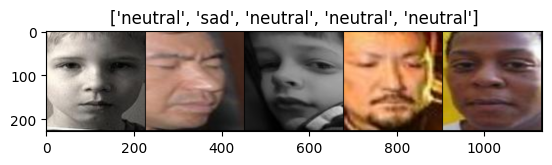

In [8]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['suprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral']

imshow(out, title=[class_names[x] for x in classes])

# 3 Model

The basic model here is simply a stack of **convolutional layers** followed by some **fully-connected layers**.

Since there are three channels for a color image (RGB), the **input channels** of the network must be **three**.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the **feature map must be flattened into a single one-dimensional vector** (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.



In [9]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.SELU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.SELU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.SELU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [10]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

In [11]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# 4 Define Loss and Optimizer

In [12]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/MMU/DeepLearning/model/best_sigmoid_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

# 6 Testing



Before making test, please make sure you have selected the best model parameters through best validation accuracy.

Idealy, you should only run the following code once in your entire deep learning model development pipeline.

In [ ]:
%%time
# load best model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/MMU/DeepLearning/model/best_sigmoid_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

batch_accs = []
actual_class = []
pred_class = []
batch_loss = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)
    batch_loss.append(loss.item())

    pred = logits.argmax(dim = -1)
    pred_class.extend(pred.tolist())

    actual_class.extend(labels.tolist())

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    batch_accs.append(acc.item())

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(batch_accs) / len(batch_accs)
print(f'Test accuracy {test_acc}')